In [68]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix

from sklearn.model_selection import KFold


In [69]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### Read in and basic overview

In [70]:
# Read csv dataset
#path_dataset = 'gdrive/My Drive/CS109BProject/data/Capital_Projects.csv'
path_dataset = '../data/Capital_Projects.csv'
df = pd.read_csv(path_dataset)
#print(df.shape)
df.replace('', np.nan, inplace=True)
# Drop nan values for the following columns
df = df.dropna(subset=['Budget Forecast', 'Total Budget Changes',
                       'Forecast Completion', 'Total Schedule Changes'], how='all')
# Only take budget forecast for positive values
df = df[df['Budget Forecast'] >= 0]
# Reset index to eliminate completely missing rows from the dataframe
df.reset_index(drop=True, inplace=True)
# Keep only last row of each project
df = df.groupby('PID').tail(1)
df.describe(include='all')

,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes
count,367,367.000000,367,364,367,181,367,283,367,356,3.670000e+02,3.140000e+02,3.140000e+02,360,307.000000,309.000000
unique,4,NaN,366,327,22,19,12,30,5,307,NaN,NaN,NaN,288,NaN,NaN
top,09/01/2019 12:00:00 AM,NaN,FUEL TANK REPLACEMENT,Design and construction of a new school,Streets and Roadways,Brooklyn,DDC,DEP,Construction,05/04/2016,NaN,NaN,NaN,09/03/2021,NaN,NaN
freq,284,NaN,2,31,81,50,168,113,172,7,NaN,NaN,NaN,17,NaN,NaN
mean,NaN,657.457766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.118842e+08,1.872939e+06,1.403277e+07,NaN,53.592834,450.158576
std,NaN,259.175801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.514155e+08,3.595631e+07,7.722460e+07,NaN,216.195431,636.282607
min,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,-2.664272e+08,-2.919002e+08,NaN,-1462.000000,-1462.000000
25%,NaN,505.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.552250e+07,0.000000e+00,-3.025000e+04,NaN,0.000000,0.000000
50%,NaN,680.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.369206e+07,0.000000e+00,1.472004e+06,NaN,0.000000,297.000000
75%,NaN,867.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.980109e+07,8.537500e+05,1.994925e+07,NaN,78.000000,816.000000


## Regression Model

In [71]:
#### (1) #### CHANGE object to datetime64[ns] for columns with dates, drop NaNs
df['Forecast Completion'] =pd.to_datetime(df['Forecast Completion'], format='%m/%d/%Y', exact=False)
df['Date Reported As Of'] = pd.to_datetime(df['Date Reported As Of'],format='%m/%d/%Y', exact=False)
df['Design Start'] = pd.to_datetime(df['Design Start'], format='%m/%d/%Y', exact=False)
date_reported_min = min(df['Date Reported As Of'])
date_min = min([min(df['Date Reported As Of']), min(df['Design Start']), min(df['Forecast Completion'])])
print(f'Minimum Date: {date_min}')
print(f'Date Reported Minimum: {date_reported_min}')
df.dtypes

Minimum Date: 1993-08-02 00:00:00
Date Reported Minimum: 2018-03-01 00:00:00


Date Reported As Of        datetime64[ns]
PID                                 int64
Project Name                       object
Description                        object
Category                           object
Borough                            object
Managing Agency                    object
Client Agency                      object
Current Phase                      object
Design Start               datetime64[ns]
Budget Forecast                   float64
Latest Budget Changes             float64
Total Budget Changes              float64
Forecast Completion        datetime64[ns]
Latest Schedule Changes           float64
Total Schedule Changes            float64
dtype: object

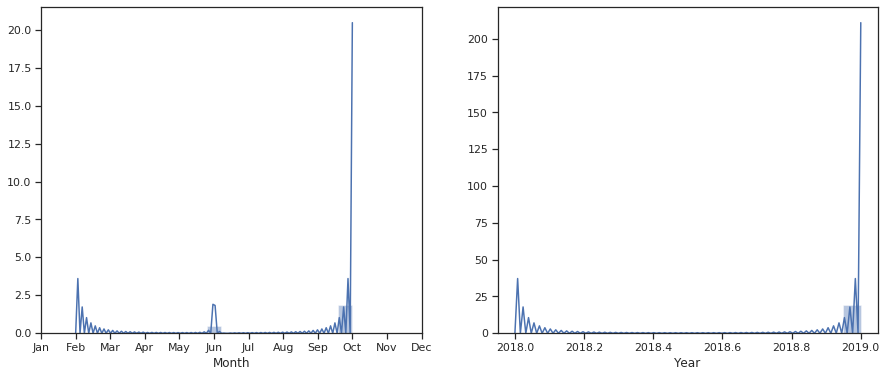

In [72]:
#### (2) #### Extract MONTH and YEAR from Date Reported
df['Month'] = df['Date Reported As Of'].dt.month
df['Year'] = df['Date Reported As Of'].dt.year
month_ticks = {0:'Jan', 1:'Feb',2:'Mar',3:'Apr',4:'May',5:'Jun',6:'Jul',7:'Aug',8:'Sep',9:'Oct',10:'Nov',11:'Dec'}
fig, axes = plt.subplots(1,2, figsize=(15,6))
sns.distplot(df['Month'], ax=axes[0])
axes[0].set_xticks(list(month_ticks.keys()))
axes[0].set_xticklabels(list(month_ticks.values()))
sns.distplot(df['Year'],ax=axes[1])
plt.show()

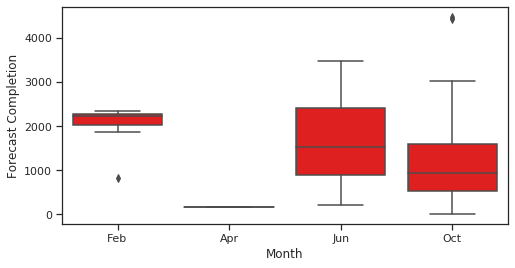

In [73]:
plt_df = df.copy()
plt_df['Forecast Completion'] = pd.to_numeric((plt_df['Forecast Completion'].copy() - min(df['Forecast Completion']))/pd.Timedelta(days=1))
plt.figure(figsize=(8,4))
sns.boxplot(
    data=plt_df,
    x='Month',
    y='Forecast Completion',
    color='red')

plt.xticks([0,1,2,3],['Feb', 'Apr', 'Jun','Oct'])
plt.show()

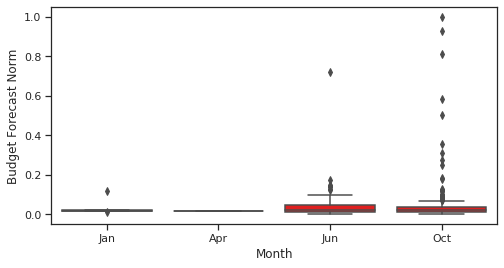

In [74]:
plt_df['Budget Forecast Norm'] = (plt_df['Budget Forecast'] - min(plt_df['Budget Forecast']))/(max(plt_df['Budget Forecast']) - min(plt_df['Budget Forecast']))
plt.figure(figsize=(8,4))
sns.boxplot(
    data=plt_df,
    x='Month',
    y='Budget Forecast Norm',
    color='red')

plt.xticks([0,1,2,3],['Jan', 'Apr', 'Jun','Oct'])
plt.show()

Max Project Duration: 9736 days 00:00:00 
 Min Project Duration: 656 days 00:00:00 


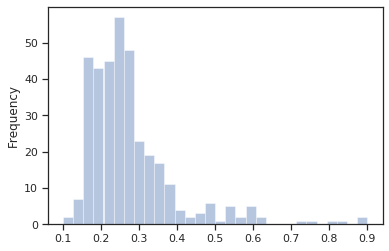

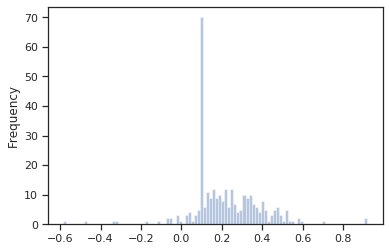

/usr/share/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/share/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


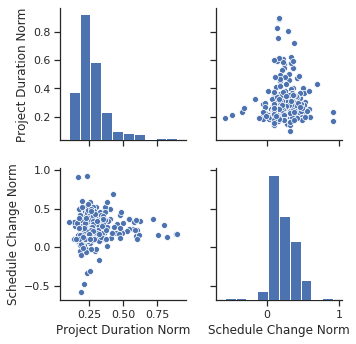

In [75]:
### (a) Schedule Change Norm ===>  Change Normalized to Project Duration of each project
### (b) Project Duration Norm ===> Normalized over all projects (to normalize across big and small projects)
df['Project Duration'] = df['Forecast Completion'] - df['Design Start']
df['Schedule Change Norm'] = (0.9-0.1)*df['Total Schedule Changes']/(df['Project Duration']/pd.Timedelta(days=1)) + 0.1
max_project_duration = max(df['Project Duration'])
min_project_duration = min(df['Project Duration'])
df['Project Duration Norm'] = (0.9 - 0.1) * (df['Project Duration'] - min_project_duration) / (max_project_duration - min_project_duration) + 0.1
print(f'Max Project Duration: {max_project_duration} \n Min Project Duration: {min_project_duration} ')
df.head()
#df[['Schedule Change Norm', 'Project Duration Norm']].plot.hist(bins=30, alpha=0.4)
df['Project Duration Norm'].plot.hist(bins=30, alpha=0.4)
plt.show()
df['Schedule Change Norm'].plot.hist(bins=100, alpha=0.4)
plt.show()
#(df['Schedule Change Norm'].ravel())
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(df[['Project Duration Norm', 'Schedule Change Norm']])

Max Budget: 2449621616.0 
 Min Budget: 0.0
Minimum Budget Change Norm: -14.067516931892621


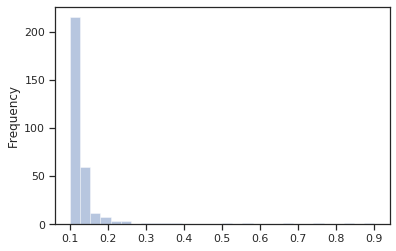

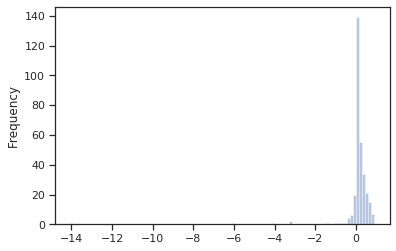

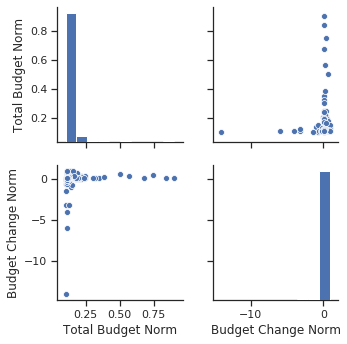

In [76]:
### (a) Budget Change Norm ===>  Budget Change Normalized to Final Budget of each project
### (b) Total Budget Norm ===> Budget Forecast Normalized through all projects
df['Budget Change Norm'] = (0.9-0.1)*df['Total Budget Changes']/df['Budget Forecast'] + 0.1
max_budget_final = max(df['Budget Forecast'])
min_budget_final = min(df['Budget Forecast'])
df['Total Budget Norm'] = (0.9-0.1)*(df['Budget Forecast'] - min_budget_final)/(max_budget_final - min_budget_final) + 0.1
print(f'Max Budget: {max_budget_final} \n Min Budget: {min_budget_final}')

# Remove outliers
df = df[df['Budget Change Norm'] >= -30]
min_budget_norm = min(df['Budget Change Norm'])
print(f'Minimum Budget Change Norm: {min_budget_norm}')
df.dtypes

#df[['Schedule Change Norm', 'Project Duration Norm']].plot.hist(bins=12, alpha=0.4)
df['Total Budget Norm'].plot.hist(bins=30, alpha=0.4)
plt.show()
df['Budget Change Norm'].plot.hist(bins=100, alpha=0.4)
plt.show()
#(df['Schedule Change Norm'].ravel())
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(df[['Total Budget Norm', 'Budget Change Norm']])

In [77]:
####  (4)  #### Handle Categorical Columns using dummy variables
categorical_columns = ['Category', 'Borough'] # not including Agencies nor Decription
nyc_df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

#### (5) #### Drop redundant or useless columns, and drop NaNs
drop_columns = ['Date Reported As Of', 'PID', 'Project Name', 'Description','Managing Agency', 
                'Client Agency', 'Design Start', 'Budget Forecast', 'Latest Budget Changes', 
                'Latest Schedule Changes', 'Total Schedule Changes', 'Total Budget Changes', 
                'Forecast Completion', 'Year', 'Month', 'Project Duration', 'Current Phase']
nyc_df = nyc_df.drop(drop_columns, axis=1)
nyc_df.describe(include='all')

,Schedule Change Norm,Project Duration Norm,Budget Change Norm,Total Budget Norm,Category_Bridges,"Category_Bridges, Streets and Roadways",Category_Ferries,Category_Health and Hospitals,"Category_Health and Hospitals, IT",Category_IT,...,"Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_Marlboro,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
count,300.000000,300.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,...,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,0.216535,0.285528,0.084831,0.140200,0.067524,0.057878,0.012862,0.016077,0.009646,0.006431,...,0.003215,0.003215,0.003215,0.006431,0.003215,0.003215,0.109325,0.045016,0.006431,0.006431
std,0.172369,0.126230,0.984646,0.088563,0.251332,0.233889,0.112860,0.125975,0.097898,0.080063,...,0.056705,0.056705,0.056705,0.080063,0.056705,0.056705,0.312549,0.207674,0.080063,0.080063
min,-0.585982,0.100000,-14.067517,0.100721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.100000,0.205529,0.099987,0.112702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.185184,0.255947,0.122375,0.119256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.323497,0.321322,0.297775,0.132607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.918994,0.900000,0.900000,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [78]:
nyc_df.shape

(311, 43)

In [79]:
nyc_df = nyc_df.dropna()
nyc_train, nyc_test = train_test_split(nyc_df, test_size=.2, random_state=90)

In [80]:
nyc_train.head()

,Schedule Change Norm,Project Duration Norm,Budget Change Norm,Total Budget Norm,Category_Bridges,"Category_Bridges, Streets and Roadways",Category_Ferries,Category_Health and Hospitals,"Category_Health and Hospitals, IT",Category_IT,...,"Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_Marlboro,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
1709,0.412576,0.186520,0.121606,0.120680,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1196,0.316667,0.266344,0.375267,0.122654,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1826,-0.025583,0.265022,0.568092,0.502124,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
901,0.457405,0.368194,0.174974,0.118449,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
711,0.467557,0.220352,0.297902,0.121980,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


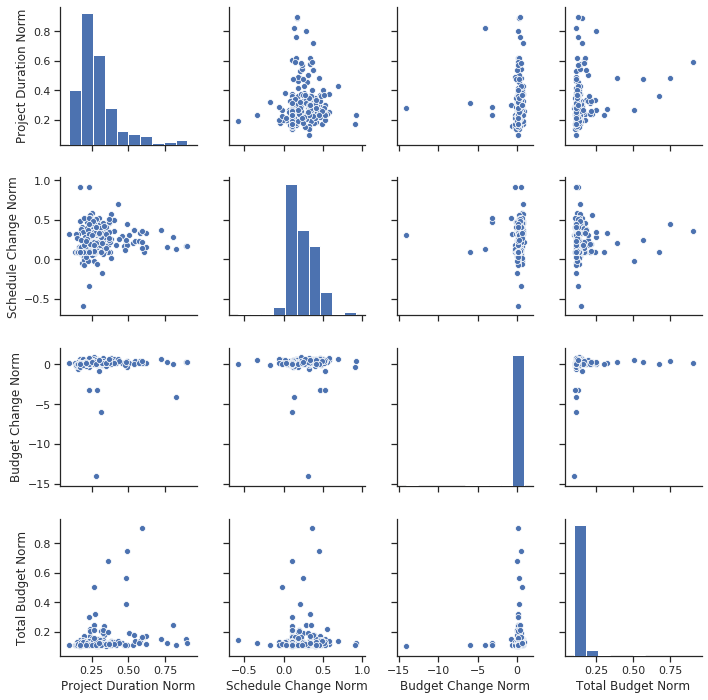

In [105]:
qual_columns = ['Project Duration Norm',	'Schedule Change Norm',
                'Budget Change Norm',	'Total Budget Norm']	
#scatter_matrix(nyc_train[qual_columns].sample(frac=0.4, axis=0),alpha=0.5, figsize=(25,20));
plt_df = nyc_train.copy()

plt_df['Budget Change Norm'] = plt_df['Budget Change Norm']
plt_df['Total Budget Norm'] = plt_df['Total Budget Norm']
plt_df['Schedule Change Norm'] = plt_df['Schedule Change Norm']
plt_df['Project Duration Norm'] = plt_df['Project Duration Norm']

# plt_df['Budget Change Norm'] = np.exp(plt_df['Budget Change Norm'])
# plt_df['Total Budget Norm'] = np.abs(plt_df['Total Budget Norm'])
# plt_df['Schedule Change Norm'] = np.exp(plt_df['Schedule Change Norm'])
# plt_df['Project Duration Norm'] = np.log(plt_df['Project Duration Norm'])

import seaborn as sns
sns.set(style="ticks")
sns.pairplot(plt_df[qual_columns])
#nyc_train = plt_df

In [82]:
nyc_train[qual_columns].corr()

,Project Duration Norm,Schedule Change Norm,Budget Change Norm,Total Budget Norm
Project Duration Norm,1.000000,0.154682,-0.026266,0.261421
Schedule Change Norm,0.154682,1.000000,-0.002217,0.039657
Budget Change Norm,-0.026266,-0.002217,1.000000,0.057005
Total Budget Norm,0.261421,0.039657,0.057005,1.000000


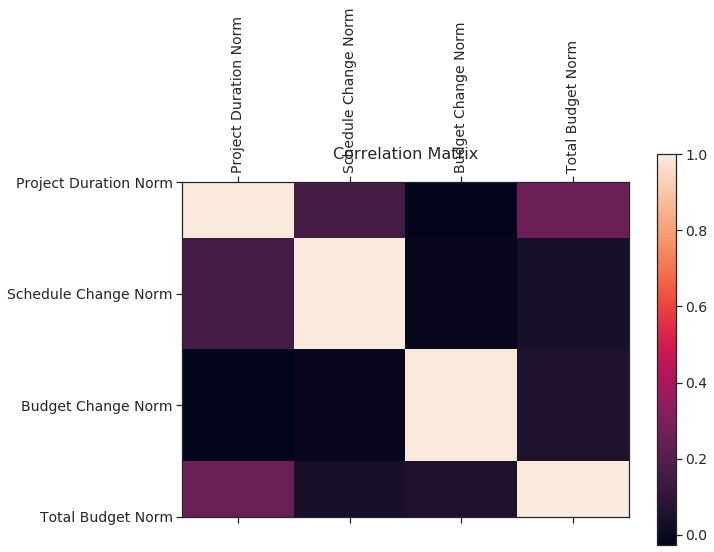

In [83]:
f = plt.figure(figsize=(10, 7))
plt.matshow(nyc_train[qual_columns].corr(), fignum=f.number)
plt.xticks(range(len(qual_columns)), qual_columns, fontsize=14, rotation=90)
plt.yticks(range(len(qual_columns)), qual_columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [103]:
# Budget change
# 'Stage', 'Project Duration', 'Forecast Completion Norm', 'Schedule Change Norm',
# 'Final Budget', 'Budget Forecast Norm', 'Budget Change Norm'
nyc_train_trunc = nyc_train.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
#y_train = np.exp(nyc_train_trunc['Budget Change Norm'])
y_train = nyc_train_trunc['Budget Change Norm']

X_train = nyc_train_trunc.drop(['Budget Change Norm', 'Schedule Change Norm'], axis=1)
#X_train = nyc_train_trunc['Stage'].ravel().reshape(-1,1)
#X_train['Total Budget Norm'] = np.log(X_train['Total Budget Norm'])
#X_train['Project Duration Norm'] = np.log(X_train['Project Duration Norm'])
#X_train['Final Budget'] = np.log(X_train['Final Budget'])
#poly = PolynomialFeatures(interaction_only=True,include_bias = False)
#X_train = poly.fit_transform(X_train)
fitted_model = LinearRegression().fit(X_train, y_train)
fitted_model.score(X_train, y_train)

# Normalization or Standardization
# DateTime => numeric - (- 2013) 
# QQ plot (normal plot)

0.056012298922725086

In [104]:
X_train = sm.add_constant(X_train)
results = OLS(y_train, X_train).fit()
results.summary()

/usr/share/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Budget Change Norm   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                 -0.119
Method:                 Least Squares   F-statistic:                    0.3328
Date:                Thu, 07 May 2020   Prob (F-statistic):               1.00
Time:                        16:28:05   Log-Likelihood:                -356.46
No. Observations:                 240   AIC:                             790.9
Df Residuals:                     201   BIC:                             926.7
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     0.2212      0.708      0.312      0.755      -1.175       1.618
Project Duration Norm                                    -0.5444      0.734     -0.741      0.459      -1.992       0.903
Total Budget Norm                                         0.7509      1.120      0.671      0.503      -1.457       2.959
Category_Bridges                                         -0.0556      0.777     -0.072      0.943      -1.588       1.477
Category_Bridges, Streets and Roadways                   -0.3432      0.744     -0.462      0.645      -1.810       1.123
Category_Ferries                                          0.2282      1.105      0.207      0.837      -1.950       2.406
Category_Health and Hospitals                            -0.2587      0.969     -0.267      0.790      -2.169       1.652
Category_Health and Hospitals, IT                      2.216e-16   4.44e-15      0.050      0.960   -8.54e-15    8.99e-15
Category_IT                                           -4.878e-16   2.59e-15     -0.188      0.851    -5.6e-15    4.63e-15
Category_Industrial Development                          -0.0252      0.719     -0.035      0.972      -1.444       1.393
Category_Industrial Development, Parks                    0.1142      1.420      0.080      0.936      -2.685       2.914
Category_Industrial Development, Streets and Roadways     0.0970      1.369      0.071      0.944      -2.602       2.796
Category_Libraries                                       -0.0906      1.074     -0.084      0.933      -2.209       2.028
Category_Other Government Facilities                      0.0568      0.810      0.070      0.944      -1.540       1.653
Category_Parks                                           -0.8738      0.810     -1.079      0.282      -2.470       0.723
Category_Parks, Streets and Roadways                  -1.522e-16   1.47e-15     -0.104      0.917   -3.04e-15    2.74e-15
Category_Public Safety and Criminal Justice               0.0049      0.793      0.006      0.995      -1.560       1.570
Category_Sanitation                                       0.0269      0.834      0.032      0.974      -1.619       1.672
Category_Schools                                         -0.2740      0.732     -0.374      0.708      -1.717       1.169
Category_Sewers                                           0.0344      0.725      0.047      0.962      -1.396       1.464
Category_Social Services                                 -0.0863      1.355     -0.064      0.949      -2.758       2.585
Category_Streets and Roadways                            -0.3611      0.700     -0.515      0.607      -1.742       1.020
Category_Wastewater Treatment    

In [86]:
# Multi-collinearity
X_train_save = X_train.copy()
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X_train.values, i) 
               for i in range(X_train.shape[1])], 
               index=X_train.columns)

/usr/share/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


const                                                    88.304571
Project Duration Norm                                     1.683238
Total Budget Norm                                         1.703347
Category_Bridges                                          6.229618
Category_Bridges, Streets and Roadways                    6.407344
Category_Ferries                                          3.520916
Category_Health and Hospitals                             2.039305
Category_Health and Hospitals, IT                              NaN
Category_IT                                                    NaN
Category_Industrial Development                           9.097773
Category_Industrial Development, Parks                    1.472322
Category_Industrial Development, Streets and Roadways     1.368185
Category_Libraries                                        1.678825
Category_Other Government Facilities                      3.267164
Category_Parks                                            3.26

In [87]:
# Remove multi-collinearity
# Transforms

X_train = X_train_save.copy()
drop_mc_columns = ['Category_Parks, Streets and Roadways', 'Category_IT', 'Category_Health and Hospitals, IT',]
X_train = X_train.drop(drop_mc_columns, axis=1)
results = OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Budget Change Norm   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.8970
Date:                Thu, 07 May 2020   Prob (F-statistic):              0.645
Time:                        16:25:27   Log-Likelihood:                -62.089
No. Observations:                 240   AIC:                             202.2
Df Residuals:                     201   BIC:                             337.9
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     1.1614      0.208      5.591      0.000       0.752       1.571
Project Duration Norm                                     0.1182      0.215      0.549      0.584      -0.306       0.543
Total Budget Norm                                        -0.0069      0.328     -0.021      0.983      -0.655       0.641
Category_Bridges                                         -0.0995      0.228     -0.436      0.663      -0.549       0.350
Category_Bridges, Streets and Roadways                   -0.1010      0.218     -0.463      0.644      -0.531       0.329
Category_Ferries                                          0.3067      0.324      0.946      0.345      -0.332       0.946
Category_Health and Hospitals                            -0.1235      0.284     -0.435      0.664      -0.684       0.437
Category_Industrial Development                           0.0601      0.211      0.285      0.776      -0.356       0.476
Category_Industrial Development, Parks                    0.5757      0.416      1.382      0.168      -0.245       1.397
Category_Industrial Development, Streets and Roadways    -0.0590      0.401     -0.147      0.883      -0.851       0.733
Category_Libraries                                       -0.0800      0.315     -0.254      0.800      -0.701       0.541
Category_Other Government Facilities                      0.1222      0.237      0.514      0.607      -0.346       0.590
Category_Parks                                           -0.2094      0.237     -0.882      0.379      -0.678       0.259
Category_Public Safety and Criminal Justice               0.0574      0.233      0.247      0.805      -0.401       0.516
Category_Sanitation                                       0.0018      0.245      0.007      0.994      -0.481       0.484
Category_Schools                                         -0.1906      0.215     -0.888      0.376      -0.614       0.233
Category_Sewers                                           0.1519      0.213      0.714      0.476      -0.268       0.571
Category_Social Services                                 -0.0807      0.397     -0.203      0.839      -0.864       0.703
Category_Streets and Roadways                             0.0105      0.205      0.051      0.959      -0.395       0.416
Category_Wastewater Treatment                            -0.0280      0.215     -0.130      0.897      -0.453       0.397
Category_Water Supply                                     0.1144      0.220      0.520      0.603      -0.319       0.548
Borough_Bronx, Manhattan                                  0.4229      0.360      1.175      0.241      -0.287       1.132
Borough_Brooklyn                 

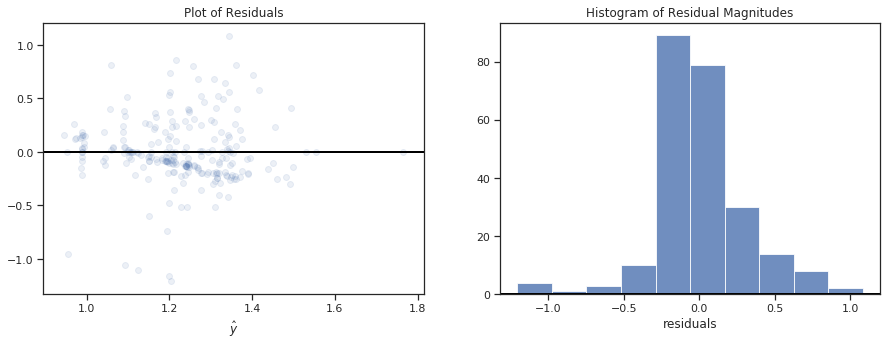

In [88]:
# Residual Plots
y_hat_train = results.predict()
residuals = (y_train - y_hat_train)
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter((y_hat_train), residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()


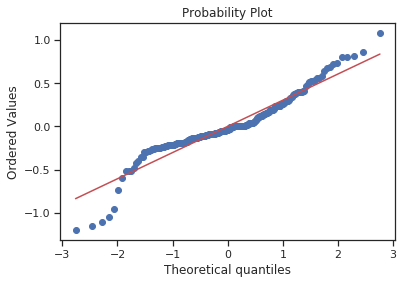

In [89]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

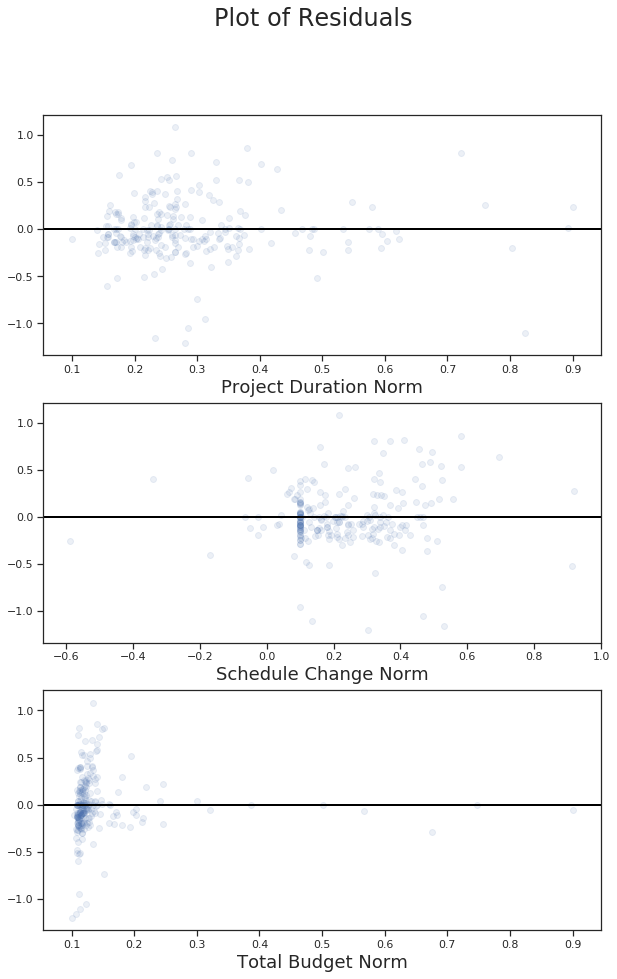

In [90]:
# Residual Plots
X_colms = ['Project Duration Norm','Schedule Change Norm','Total Budget Norm']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(3,1,figsize=(10,15))
fig.suptitle('Plot of Residuals', fontsize=24)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=18)
plt.show()

In [91]:
# Schedule change
y_train = np.exp(nyc_train['Schedule Change Norm'])
X_train = nyc_train.drop(['Budget Change Norm', 'Schedule Change Norm'], axis=1)
X_train['Total Budget Norm'] = np.log(X_train['Total Budget Norm'])
X_train['Project Duration Norm'] = np.log(X_train['Project Duration Norm'])
drop_mc_columns = ['Category_Parks, Streets and Roadways', 'Category_IT', 'Category_Health and Hospitals, IT',]
X_train = X_train.drop(drop_mc_columns, axis=1)
fitted_model = LinearRegression().fit(X_train, y_train)
fitted_model.score(X_train, y_train)

0.2691272767785402

In [92]:
X_train = sm.add_constant(X_train)
results = OLS(y_train, X_train).fit()
results.summary()

/usr/share/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Schedule Change Norm   R-squared:                       0.269
Model:                              OLS   Adj. R-squared:                  0.131
Method:                   Least Squares   F-statistic:                     1.948
Date:                  Thu, 07 May 2020   Prob (F-statistic):            0.00178
Time:                          16:25:28   Log-Likelihood:                 51.127
No. Observations:                   240   AIC:                            -24.25
Df Residuals:                       201   BIC:                             111.5
Df Model:                            38                                         
Covariance Type:              nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     1.3088      0.180      7.253      0.000       0.953       1.665
Project Duration Norm                                     0.0150      0.051      0.295      0.768      -0.085       0.115
Total Budget Norm                                        -0.0212      0.061     -0.350      0.727      -0.141       0.098
Category_Bridges                                         -0.0454      0.142     -0.319      0.750      -0.326       0.235
Category_Bridges, Streets and Roadways                   -0.1059      0.136     -0.777      0.438      -0.375       0.163
Category_Ferries                                         -0.0821      0.203     -0.405      0.686      -0.482       0.318
Category_Health and Hospitals                            -0.1463      0.179     -0.815      0.416      -0.500       0.208
Category_Industrial Development                          -0.1661      0.132     -1.262      0.208      -0.426       0.093
Category_Industrial Development, Parks                   -0.3287      0.262     -1.253      0.211      -0.846       0.188
Category_Industrial Development, Streets and Roadways    -0.1520      0.252     -0.604      0.546      -0.648       0.344
Category_Libraries                                       -0.2236      0.197     -1.137      0.257      -0.611       0.164
Category_Other Government Facilities                     -0.1211      0.148     -0.817      0.415      -0.414       0.171
Category_Parks                                           -0.1763      0.148     -1.190      0.236      -0.468       0.116
Category_Public Safety and Criminal Justice              -0.2057      0.145     -1.417      0.158      -0.492       0.081
Category_Sanitation                                      -0.1892      0.153     -1.236      0.218      -0.491       0.113
Category_Schools                                         -0.2648      0.134     -1.970      0.050      -0.530       0.000
Category_Sewers                                          -0.0766      0.133     -0.577      0.565      -0.338       0.185
Category_Social Services                                 -0.2276      0.248     -0.918      0.360      -0.717       0.261
Category_Streets and Roadways                            -0.0515      0.128     -0.401      0.689      -0.305       0.202
Category_Wastewater Treatment                             0.0456      0.134      0.340      0.734      -0.219       0.311
Category_Water Supply                                    -0.0669      0.137     -0.488      0.626      -0.338       0.204
Borough_Bronx, Manhattan                                 -0.0427      0.225     -0.190      0.849      -0.486       0.400
Borough_Bro

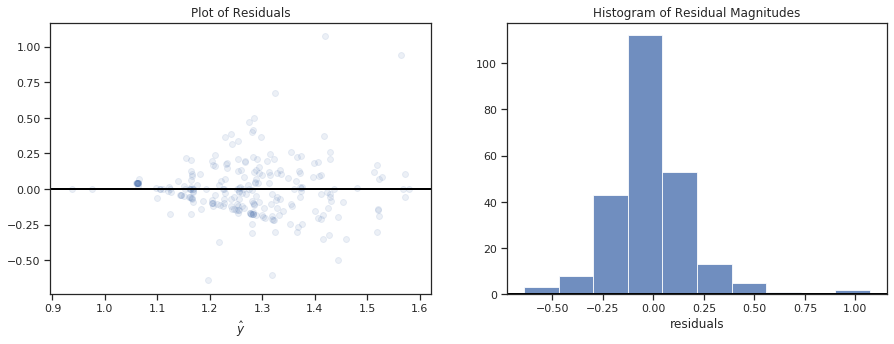

In [93]:
# Residual Plots
y_hat_train = results.predict()
residuals = y_train - y_hat_train
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()

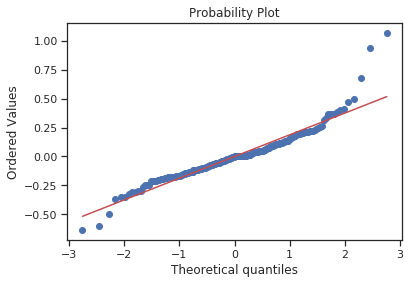

In [94]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()
plt.show()

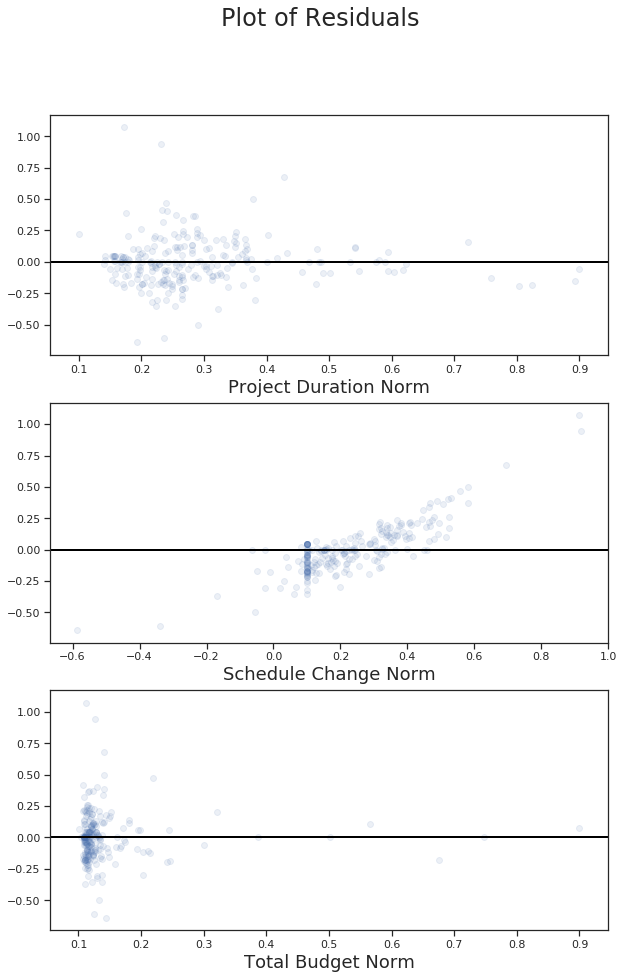

In [95]:
# Residual Plots
# Residual Plots
X_colms = ['Project Duration Norm','Schedule Change Norm','Total Budget Norm']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(3,1,figsize=(10,15))
fig.suptitle('Plot of Residuals', fontsize=24)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=18)
plt.show()

# GAM

In [96]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder


In [97]:
print(X_train.shape)
X_train.drop(labels = ['const'], axis = 1, inplace = True)
X_train.head()


(240, 39)


,Project Duration Norm,Total Budget Norm,Category_Bridges,"Category_Bridges, Streets and Roadways",Category_Ferries,Category_Health and Hospitals,Category_Industrial Development,"Category_Industrial Development, Parks","Category_Industrial Development, Streets and Roadways",Category_Libraries,...,"Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_Marlboro,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
1709,-1.679218,-2.114612,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1196,-1.322968,-2.098386,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1826,-1.327942,-0.688909,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
901,-0.999146,-2.133275,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
711,-1.512527,-2.103902,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [98]:
y_train = pd.DataFrame(np.exp(nyc_train['Schedule Change Norm']))
#y_train = np.exp(nyc_train_trunc['Budget Change Norm'])
y_train.shape

(240, 1)

In [99]:
smoothings = np.logspace(-3, 6, 9)
cv = 10

kf = KFold(n_splits=cv, random_state=42, shuffle=True)
scores = np.zeros((cv,len(smoothings)))

print(smoothings,'\n')
print(scores.shape, '\n')
print(type(kf))

[1.00000000e-03 1.33352143e-02 1.77827941e-01 2.37137371e+00
 3.16227766e+01 4.21696503e+02 5.62341325e+03 7.49894209e+04
 1.00000000e+06] 

(10, 9) 

<class 'sklearn.model_selection._split.KFold'>


In [100]:
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    train_df = X_train.iloc[train_index,:]
    test_df = X_train.iloc[test_index,:]
    train_y = y_train.iloc[train_index,:]
    test_y = y_train.iloc[test_index,:]
    
    for j, smoothing in enumerate(smoothings):
        cur_model = LinearGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11), lam = smoothing).fit(train_df, train_y)
        scores[i,j] = r2_score(test_y, cur_model.predict(test_df))
                              
best_lambda = smoothings[np.argmax(np.mean(scores, axis = 0))]
best_lambda

31.622776601683793

In [101]:
nyc_gam1 = LinearGAM(s(0) + s(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + f(16) + f(17) + f(18) + f(19) + f(20) + f(21) + f(22) + f(23) + f(24) + f(25) + f(26) + f(27) + f(28) + f(29) + f(30) + f(31) + f(32) + f(33) + f(34) + f(35) + f(36),
                       lam=best_lambda).fit(X_train, y_train)
r_score_train = r2_score(y_train, nyc_gam1.predict(X_train))
#r_score_test = r2_score(airbnb_test.price, airbnb_gam.predict(airbnb_test))


print('\n###########################################################\n')
print('Lambda = {:0.3f}'.format(best_lambda))
print('Training R-Squared = {:0.5f}'.format(r_score_train))
#print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')
print(nyc_gam1.summary())


###########################################################

Lambda = 31.623
Training R-Squared = 0.21063

###########################################################

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     17.2451
Link Function:                     IdentityLink Log Likelihood:                                 -1976.7064
Number of Samples:                          240 AIC:                                             3989.9031
                                                AICc:                                            3993.0842
                                                GCV:                                                0.0511
                                                Scale:                            

/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  if sys.path[0] == '':


In [102]:
X_test.head()

NameError: name 'X_test' is not defined